## Project 

To motivate the main reasons for implementing these procedures, think of an example of solving a Bewley-Huggett-Aiyagari model (to be included later) with Envelope Condition Methods (approximating the value function):
- If using the more efficient Newton iteration instead of Bellman iteration, we need to perform operations directly on the basis matrices (so numpy given cheb.fit is not enough)
- Usually we can precompute some basis matrices (eg for shocks) and so we can save time by simply calculating the basis matrix for the endogenous state and take the tensor product with the other precomputed matrices
- Sometimes monomial basis has some advantages, see eg.: Judd,Maliar and Maliar (2011) , where thanks to their simplicity, expectation of the value function is calculated only once.


In [2]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
%matplotlib inline

## Low level functions
Including: 
- dprod: evaluates the tensor product of matrix A and B used for multidimensional approximation
- Chebyshev nodes  - different from the numpy version as both endpoints and Lobatto nodes are included
- Monomial and Chebyshev basis matrix
- Monomial and Chebyshev difference operator

Need:
- Splines -  so far only copied the code, I have to check through it as it is memoized

In [3]:
@jit
def dprod(A,B):
    nobsa,na= A.shape
    nobsb,nb= B.shape
    Res= np.empty((nobsa,nb*na))
    if (nobsa!=nobsb):
        return 'A and B must have same number of rows'
    for t in range(nobsa):
        for ia in range(na):
            for ib in range(nb):            
                Res[t,nb*(ia-1)+ib]=A[t,ia] * B[t, ib]
    return Res

In [4]:
@jit
def Chebnodes(p, nodetype=0): # Cheb nodes- 1d
    n, a, b = p[0], p[1], p[2]
    s = (b-a) / 2 
    m = (b+a) / 2  
    if (nodetype < 2):  # usual nodes
        k = np.pi*np.linspace(0.5,n-0.5,n)  
        x = m - np.cos(k[0:n]/n) * s  
        if (nodetype == 1):  # Extend nodes to endpoints
            aa = x[0]  
            bb = x[-1]  
            x = (bb*a - aa*b)/(bb-aa) + (b-a)/(bb-aa)*x
    else: # Lobatto nodes
        k = np.pi*np.linspace(0,n-1,n)
        x = m - np.cos(k[0:n]/(n-1)) * s
    return x

In [5]:
@jit
def Chebbasex(p, x): # Cheb basis matrix - 1d
    n, a, b = p[0], p[1], p[2]
    z = (2/(b-a)) * (x-(a+b)/2)
    m = z.shape[0]
    bas = np.empty((m, n));
    bas[:, 0] = 1.0
    bas[:, 1] = z[:]
    z = 2 * z
    for i in range(m):
        for j in range(2,n):
            bas[i, j] = z[i] * bas[i, j-1] - bas[i, j-2]
    return bas

In [6]:
@jit
def Monobasex(p, x):  # Monomials basis matrix- 1d
    n, a, b = p[0], p[1], p[2]
    z = (2/(b-a)) * (x-(a+b)/2)
    m = z.shape[0]
    bas = np.empty((m, n));
    bas[:, 0] = 1.0
    for i in range(m):
        for j in range(1,n):
            bas[i, j] = z[i] * bas[i, j-1]
    return bas

In [7]:
@jit
def ChebDiffMatrix(p):  
    n, a, b = p[0], p[1], p[2]  #Differentiating matrix for Chebyshev polynomials
    D= np.zeros((n,n))
    for j in range(n):
        for i in range(int((n-j)/2)):
            D[j,j+1+2*i]=4*((2*i+j+1))/(b-a)
    D[0,:] = D[0,:]/2
    return D

In [8]:
@jit
def MonoDiffMatrix(p):  
    n, a, b = p[0], p[1], p[2]  #Differentiating matrix for mononomials - loops are faster then vectorizing
    D= np.zeros((n,n))
    for j in range(n-1):
        D[j,j+1]=(j+1)/(b-a)*2
    return D

In [ ]:
# Forked from johntfoster/bspline
# Claimed to be two orders of magnitude faster 
from functools import partial

class memoize(object):
    """
       Cache the return value of a method
        
       This class is meant to be used as a decorator of methods. The return value
       from a given method invocation will be cached on the instance whose method
       was invoked. All arguments passed to a method decorated with memoize must
       be hashable.
        
       If a memoized method is invoked directly on its class the result will not
       be cached. Instead the method will be invoked like a static method:
       class Obj(object):
           @memoize
           def add_to(self, arg):
               return self + arg
       Obj.add_to(1) # not enough arguments
       Obj.add_to(1, 2) # returns 3, result is not cached
        
       Script borrowed from here:
       MIT Licensed, attributed to Daniel Miller, Wed, 3 Nov 2010
       http://code.activestate.com/recipes/577452-a-memoize-decorator-for-instance-methods/
    """
    def __init__(self, func):
        self.func = func
    def __get__(self, obj, objtype=None):
        if obj is None:
            return self.func
        return partial(self, obj)
    def __call__(self, *args, **kw):
        obj = args[0]
        try:
            cache = obj.__cache
        except AttributeError:
            cache = obj.__cache = {}
        key = (self.func, args[1:], frozenset(kw.items()))
        try:
            res = cache[key]
        except KeyError:
            res = cache[key] = self.func(*args, **kw)
        return res



class Bspline():
    """
       Numpy implementation of Cox - de Boor algorithm in 1D
       inputs:
           knot_vector: Python list or Numpy array containing knot vector 
                        entries
           order: Order of interpolation, e.g. 0 -> piecewise constant between 
                  knots, 1 -> piecewise linear between knots, etc.
       outputs:
           basis object that is callable to evaluate basis functions at given 
           values of knot span
    """
    
    def __init__(self, knot_vector, order):
        """Initialize attributes"""
        self.knot_vector = np.array(knot_vector)
        self.p = order

        #Dummy calls to the functions for memory storage
        self.__call__(0.0)
        self.d(0.0)
        
        
    def __basis0(self, xi):
        """Order zero basis"""
        return np.where(np.all([self.knot_vector[:-1] <=  xi, 
                                xi < self.knot_vector[1:]],axis=0), 1.0, 0.0)
    
    def __basis(self, xi, p, compute_derivatives=False):
        """
           Recursive Cox - de Boor function to compute basis functions and 
           optionally their derivatives
        """
        
        if p == 0:
            return self.__basis0(xi)
        else:
            basis_p_minus_1 = self.__basis(xi, p - 1)
        
        first_term_numerator = xi - self.knot_vector[:-p] 
        first_term_denominator = self.knot_vector[p:] - self.knot_vector[:-p]
        
        second_term_numerator = self.knot_vector[(p + 1):] - xi
        second_term_denominator = (self.knot_vector[(p + 1):] - 
                                   self.knot_vector[1:-p])
                
        
        #Change numerator in last recursion if derivatives are desired
        if compute_derivatives and p == self.p:
            
            first_term_numerator = p
            second_term_numerator = -p
            
        #Disable divide by zero error because we check for it
        with np.errstate(divide='ignore', invalid='ignore'):
            first_term = np.where(first_term_denominator != 0.0, 
                                  (first_term_numerator / 
                                   first_term_denominator), 0.0)
            second_term = np.where(second_term_denominator != 0.0,
                                   (second_term_numerator / 
                                    second_term_denominator), 0.0)
        
        return  (first_term[:-1] * basis_p_minus_1[:-1] + 
                 second_term * basis_p_minus_1[1:])
            
    
    @memoize
    def __call__(self, xi):
        """
           Convenience function to make the object callable.  Also 'memoized'
           for speed.
        """
        return self.__basis(xi, self.p, compute_derivatives=False)
    
    @memoize
    def d(self, xi):
        """
           Convenience function to compute derivate of basis functions.  
           'Memoized' for speed.
        """
        return self.__basis(xi, self.p, compute_derivatives=True)
    
    def plot(self):
        """
           Convenience function to plot basis functions over full 
           range of knots.
        """
        
        x_min = np.min(self.knot_vector)
        x_max = np.max(self.knot_vector)
        
        x = np.linspace(x_min, x_max, num=1000)
        
        N = np.array([self(i) for i in x]).T;
        
        for n in N:
            
            plt.plot(x,n)
            
        return plt.show()
    
    def dplot(self):
        """
           Convenience function to plot derivatives of basis functions over 
           full range of knots.
        """
        
        x_min = np.min(self.knot_vector)
        x_max = np.max(self.knot_vector)
        
        x = np.linspace(x_min, x_max, num=1000)
        
        N = np.array([self.d(i) for i in x]).T;
        
        for n in N:
            
            plt.plot(x,n)
            
        return plt.show()

## High level functions
Including: 
- funbas - creates the multidimensional basis matrix
- Could include a routine to efficiently calculate the coefficients
Need:
- High level extension for Chebnodes - easy

In [8]:
def funbas(p,x,order,polynomial):
    if x.ndim==1:
        if polynomial=='Cheb':
            Phi0=Chebbasex(p, x) @ np.linalg.matrix_power(ChebDiffMatrix(p),order[0])
        elif (polynomial=='Mono'):
            Phi0=Monobasex(p, x) @ np.linalg.matrix_power(MonoDiffMatrix(p),order[0])
    else:
        Phi0=np.ones((x.shape[0],1))       
        for j in range(x.shape[1]):
            if polynomial[j]=='Cheb':
                Phi1=Chebbasex(p[j,:], x[:,j]) @ np.linalg.matrix_power(ChebDiffMatrix(p[j,:]),order[j])
            elif (polynomial[j]=='Mono'):
                Phi1=Monobasex(p[j,:], x[:,j]) @ np.linalg.matrix_power(MonoDiffMatrix(p[j,:]),order[j])
            Phi0=dprod(Phi0,Phi1)
    return Phi0

## Test Functions
Examples for: 
- dprod for large matrices
- Approximating cos(x) and it's derivative using monomials and Chebyshev polynomial
- Approximate the multidimensional banana function and plot the approximation error

In [9]:
%%timeit
A1=np.random.randn(100,10)
B1=np.random.randn(100,1000)
C1=dprod(A1,B1)

The slowest run took 119.77 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 9.46 ms per loop


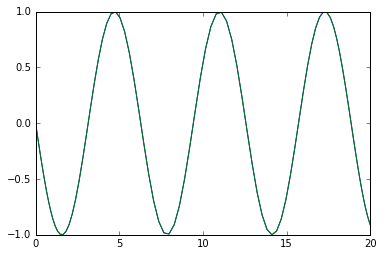

In [10]:
#Approximate cos(x) with Chebychev
n=20 # number of nodes
x=Chebnodes((n,0,20),2)  #create the Chebychev (Lobatto) nodes
y= np.cos(x) 
Phi=Chebbasex((n,0,20),x) # create the basis matrix
#Invert to get polynomial coefficients
coeff= np.linalg.inv(Phi) @ y  #get the coefficients
D=ChebDiffMatrix((n,0,20))
x1=Chebnodes((100,0,20),0)
y1=np.cos(x1)
z1=-np.sin(x1)
Phi1=Chebbasex((n,0,20),x1)
y_approx= Phi1 @ coeff
z_approx= Phi1 @ D @ coeff    #Approximate the derivative using the difference operator
plt.plot(x1,z1)
plt.plot(x1,z_approx)
plt.show()

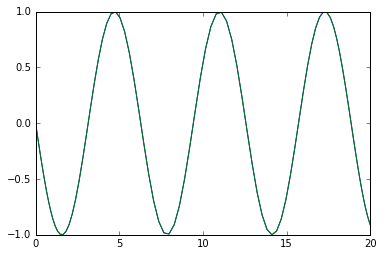

In [11]:
#Approximate cos(x) with monomial
n=20
x=Chebnodes((n,0,20),2)
y= np.cos(x)
Phi=Monobasex((n,0,20),x)
#Invert to get polynomial coefficients
coeff= np.linalg.inv(Phi) @ y
D=MonoDiffMatrix((n,0,20))
x1=Chebnodes((100,0,20),0)
y1=np.cos(x1)
z1=-np.sin(x1)
Phi1=Monobasex((n,0,20),x1)
y_approx= Phi1 @ coeff
z_approx= Phi1 @ D @ coeff
plt.plot(x1,z1)
plt.plot(x1,z_approx)
plt.show()

In [12]:
# Approximate the banana function
n= 20
P=np.array(((n,-3,3),(n,-3,3)))
Polyname= ('Cheb','Mono')
Order=(0,0)
x=Chebnodes(P[0,:],2)
s=np.concatenate([np.transpose(np.kron(x,np.ones((1,n)))),np.transpose(np.kron(np.ones((1,n)),x))],1)
#The banana - vectorized
def Banana(s):
    return (1-s[:,0])**2 + 100 * (s[:,1]-s[:,0]**2)**2
y=Banana(s)
Phi3 = funbas(P,s,Order,Polyname)
coeff= np.linalg.inv(Phi3) @ y
#Generate the approximand
n1=100
x1=np.linspace(-3,3,n1)
s1=np.concatenate([np.transpose(np.kron(x1,np.ones((1,n1)))),np.transpose(np.kron(np.ones((1,n1)),x1))],1)
y1=Banana(s1)
Phi3a = funbas(P,s1,Order,Polyname)
y_approx= Phi3a @ coeff

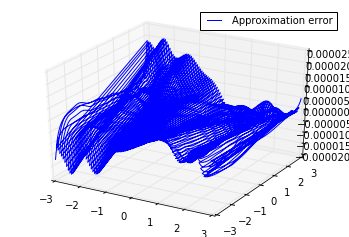

In [13]:
#3D Plot
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(s1[:,0], s1[:,1], y1-y_approx, label='Approximation error')
ax.legend()

plt.show()